# Seminario de computación científica

## Introducción
En este seminario vamos a introducir herramientas de dos ramas de la computación científica (álgebra computacional y cálculo numérico) para ilustrar como los conocimientos adquiridos en esta asignatura se pueden extender y complementar usando herramientas computacionales.

**Álgebra computacional**: El cálculo simbólico o algebra computacional se dedica al estudio y desarrollo de algoritmos y librerías para la manipulación de expresiones matemáticas.

**Cálculo numérico**: El análisis numérico o cálculo numérico se ocupa del estudio y diseño de algoritmos para obtener soluciones numéricas aproximadas a los problemas de matemática continua.

**Computación científica**: La computación científica o ciencia computacional es el campo de estudio relacionado con la construcción de modelos matemáticos y técnicas numéricas para resolver problemas científicos y problemas de ingeniería. Engloba tanto el álgebra computacional como el cálculo numérico y se usa en todos los campos de la ciencia y la ingeniería.

La diferenciación automática, por ejemplo, es una variante de la derivación simbólica y se suele considerar parte del álgebra computacional. Por contra, los algoritmos de optimización numèrica són uno de los elementos más populares y estudiados del cálculo numérico. Combinados, la diferenciación automática y la optimización numérica son la base de todos los sistemas de "machine learning" y "artificial intelligence" actuales.

En general, la resolución de problemas científicos hoy en día requiere en mayor o menor medida de computación científica, a menudo combinando las distintas ramas mencionadas.

**Librerías para computación científica en Python**: En este seminario vamos a usar las librerías de Python para computación científica más populares y comunes, pero no son ni por asomo las únicas librerías de Python de este tipo.

* **NumPy**: Es la librería base para trabajar con _arrays_ (similares a listas, matrices o conjuntos de matrices). Se encarga de todas las operaciones básicas (tanto matemáticas como lógicas), y las más comunes del resto de operaciones como por ejemplo álgebra lineal o transformadas de Fourier.
* **SciPy**: Es una librería recopilatorio de algoritmos de cálculo numérico que se pueden usar con objetos de NumPy.

In [1]:
import numpy as np
from scipy.optimize import root_scalar

## Ejemplo práctico: sistema de ventilación de un mercado municipal

Nos han encargado el diseño del sistema de ventilación y filtraje de aire del nuevo mercado municipal de Barcelona.

Estamos considerando la instalación de multiples sistemas bomba+filtro para asegurarnos que cumplimos con todas las especificaciones establecidas por ley. Principalmente, que el sistema de ventilación debe renovar como mínimo un volumen de aire equivalente al volumen del local cada hora. 

### a) Número de bombas del sistema
Los sistemas bomba+filtro que estamos considerando bombean una cantidad de aire que depende del tiempo que ha pasado desde el último cambio de filtro y de la potencia a la que esté operando el sistema (para la cual hay 3 configuraciones: 0, 1 o 2).

Sabemos que los filtros se van a cambiar una vez a la semana, que el volumen del mercado es de $9 \text{dam}^3$ y que el caudal de aire procesado por un sistema bomba+filtro sigue la siguente función ($p={0, 1, 2}$ índice de la potencia):

$$
F_{procesado}(t, p) = 3 e^{-\frac{t}{300}} (\frac{t}{240}+1)^{-3+p}\quad [\text{dam}^3/\text{h}]; \qquad t>0
$$

**Cuantas bombas habrá que instal·lar?**

Una semana tiene 168 horas. Podríamos calcular cual es el volumen procesado en cada una de estas 168 horas, pero si nos fijamos en $F_{procesado}(t, p)$,
nos damos cuenta de lo siguente:

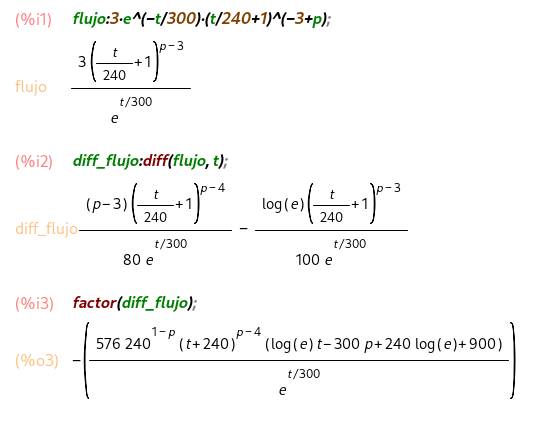

El único término negativo en toda la expresión es $300p$, pero se suma a un $900$. Como $p$ es como máximo $2$, la derivada siempre va a ser negativa, la función siempre decrece.

Consecuentemente, podemos reducir nuestro cálculo a la comprobación de que _el volumen procesado durante la última hora de la semana a potencia $p=2$_ es igual al volumen del mercado.
Es decir, tenemos que calcular cuanto vale la siguente integral:

$$
\int_{167}^{168} 3 e^{-\frac{t}{300}} (\frac{t}{240}+1)^{-1} dt
$$

Desafortunadamente, no tiene solución analítica como podéis comprobar con Maxima:

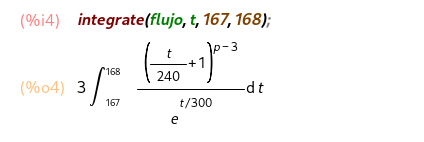

**Cálculo de volumen con cálculo numérico**

Hay varios metodos para aproximar una integral unidimensional numéricamente. Para este seminario vamos a ver la suma de Riemann como método de integración numérica.

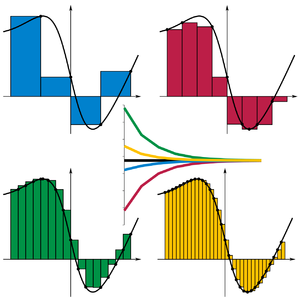

In [2]:
def flujo(t, p):
    return 3*np.exp(-t / 300) * (t/240+1)**(-3+p)

In [3]:
grid = np.linspace(24*7-1, 24*7, 100)
midpoints = (grid[:-1] + grid[1:])/2
width = grid[1]-grid[0]

processed_volume = np.sum(flujo(midpoints, 2))*width
9 / processed_volume

8.902623290454022

> Hacen falta 9 sistemas bomba+filtro.

### b) Operación del sistema: elección de la potencia

Necesitamos 9 sistemas bomba+filtro, pero cuales són las horas en que tenemos que cambiar la potencia a la que operan?

Nos interesa minimizar el consumo, por tanto, empezar a potencia $p=0$, pasado un tiempo $T_1$ cambiar a potencia $p=1$ y, pasado otro intervalo $T_2$, cambiar a $p=2$, que ya se mantiene hasta el cambio de filtros, donde el ciclo vuelve a empezar.

Nota: por simplicidad, asumimos que los 9 sistemas no se pueden controlar independientemente.

Definimos el volumen procesado durante una hora en función de la hora de la semana:

$$
V(T) = \int_T^{T+1} 9F_{procesado}(t, p) dt \quad [\text{dam}^3]
$$

y nos queda para solucionar la siguiente ecuación:

\begin{align}
V(T) - V_{mercado} &= 0 \\
\\
9\int_T^{T+1} 3 e^{-\frac{t}{300}} (\frac{t}{240}+1)^{-3+p}dt - 9 &= 0
\end{align}

Si solucionamos con $p=0$ encontramos $T_1$, con $p=1$ encontramos $T_2$.

**Búsqueda de raíces numéricamente**
Para encontrar raíces de una función o solucionar ecuaciones podemos usar el metodo de la bisección:

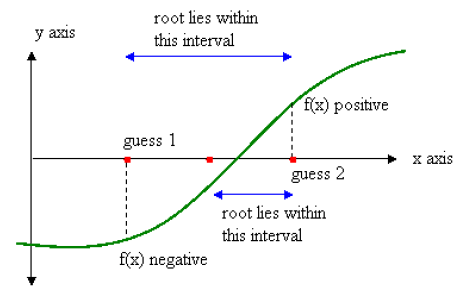

En este caso además, cada evaluación de la ecuación requiere solucionar la ecuación:

In [4]:
def V(T, p):
    grid = np.linspace(T, T+1, 100)
    midpoints = (grid[:-1] + grid[1:])/2
    width = grid[1]-grid[0]
    
    return np.sum(9*flujo(midpoints, p), axis=0)*width

def eq(T, p):
    return V(T, p) - 9

In [5]:
root_scalar(
    eq,                 # equation to be solved as python function
    bracket=(0, 24*7),  # interval containing the root
    method="bisect",
    args=(0,),          # extra arguments for function, here p
) # the root in the output is the solution

      converged: True
           flag: converged
 function_calls: 49
     iterations: 47
           root: 77.06026910325846

In [6]:
root_scalar(
     eq,                 # equation to be solved as python function
    bracket=(0, 24*7),  # interval containing the root
    method="bisect",
    args=(1,),          # extra arguments for function, here p
) # the root in the output is the solution

      converged: True
           flag: converged
 function_calls: 49
     iterations: 47
           root: 107.003477230128

> Al cabo de 77h cambiaremos de potencia 0 a 1 y, al cabo de 107h, de potencia 1 a 2. Al terminar la semana y cambiar los filtros vuelve a empezar el ciclo.

### c) Operación del sistema: refrigeración

La temperatura del sistema bomba+filtro esta relacionada con el flujo de aire procesado recientemente, y con el tiempo que hace que el sistema funciona ininterrompudamente. Según las especificaciones del sistema, la temperatura se puede expresar con la siguiente función:

$$
Temp(t) = 10^6\frac{\log(t+10)}{(t+300)^2}
$$

Tenemos que asegurarnos que la temperatura nunca supere los 40ºC, en caso que los superase habría que instal·lar también un sistema de refrigeración.

Podemos derivar e igualar a zero, pero va a ser engorroso y lo más probable es que la derivada igualada a zero sea una ecuación trascendente.

En la celda inferior, hay una función (`newton_raphson`) que permite encotrar extremos relativos de una función. Ahora bien, para hacerlo, necesita tanto la primera como la segunda derivada de la función (y una conjetura inicial).

A priori parece no solucionar nada, pero si combinamos Maxima para calcular las derivadas con esta función, podemos encontrar extremos de modo casi automático:

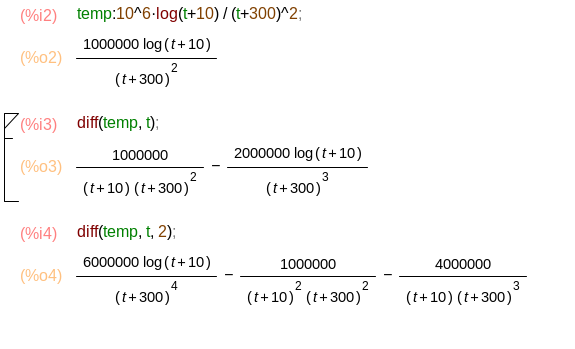

In [7]:
def temp(t):
    return 1e6*np.log(t+10) / (t+300)**2

def dtemp_dt(t):
    return 1e6/(t+10)/(t+300)**2-2e6*np.log(t+10)/(t+300)**3

def d2temp_dt2(t):
    return 6e6*np.log(t+10)/(t+300)**4-1e6/(t+10)**2/(t+300)**2-4e6/(t+10)/(t+300)**3

def newton_raphson(func, dfunc, d2func, x0):
    for i in range(100):
        df_x0 = dfunc(x0)
        if np.abs(df_x0) < 1e-10:
            break
        x0 = x0 - df_x0/d2func(x0)
    return {"sol": x0, "iterations": i, "tol": df_x0}

In [8]:
newton_raphson(
    # funciones python+numpy con un solo argumento (t-> tiempo en horas)
    temp,       # ... que evalue la función temperatura
    dtemp_dt,   # ... que evalue la derivada de la función temperatura
    d2temp_dt2, # ... que evalue la 2a derivada de la función temperatura
    # conjetura inicial, valor de t a partir del cual newton_raphson
    #  va iterando hacia regiones con derivada nula
    0
)

{'sol': 34.11565879938485, 'iterations': 7, 'tol': 4.049260926564102e-13}

In [9]:
temp(34.1156)

33.921918412362245

> La temperatura máxima del sistema se consigue al cabo de 34h 6' del cambio de filtro, llegando a 33.9ºC. No hace falta sistema de refrigeración.